**Heteroskedasticity Testing and solve problem:**  
   This part involves testing for heteroskedasticity to assess whether there's variance inconsistency in the model. Additionally, we employed Weighted Least Squares (WLS) to address this issue.

## Heteroskedasticity

In [ ]:

pip install statsmodels numpy pandas matplotlib seaborn


In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.formula.api import ols

sns.set(style="whitegrid")

In [ ]:
pip install openpyxl

**Importing dataset**

In [34]:
#Read data
file_path = r"C:\Users\ADMIN\Documents\FINAL-DATA.xlsx"
data = pd.read_excel(file_path)
df = pd.DataFrame(data)
df.head()

,Country Name,ISO,Year,Continent,Population (thousands),Life Expectancy (years),Ladder of life (Wellbeing) (0-10),Carbon Footprint (tCO2e),HPI,GDP per capita ($),Annual precipitation,Average years of schooling,Gini coefficient,GNI,Unemployment
0,Algeria,DZA,2011,Africa,36543.5,74.1,5.32,2.75,48.0,11114,82.46702,7.286604,0.276157,5050,9.96
1,Armenia,ARM,2011,Asia,2929.0,73.3,4.26,3.22,37.3,9551,953.70953,11.194550,0.293529,3360,18.44
2,Austria,AUT,2011,Europe,8391.2,80.8,7.47,14.52,44.1,53179,1024.22410,11.711150,0.308010,50700,4.56
3,Belarus,BLR,2011,Europe,9707.0,71.5,5.23,5.39,38.5,18274,635.04770,11.380924,0.271525,6350,6.17
4,Belgium,BEL,2011,Europe,10955.7,80.4,7.11,20.59,34.4,48155,788.48303,11.469870,0.280604,46370,7.14


**Data Cleaning** 

In [35]:
df = df.drop_duplicates()
df.shape

(619, 15)

In [36]:
df.isnull().sum()

Country Name                         0
ISO                                  0
Year                                 0
Continent                            0
Population (thousands)               0
Life Expectancy (years)              0
Ladder of life (Wellbeing) (0-10)    0
Carbon Footprint (tCO2e)             0
HPI                                  0
GDP per capita ($)                   0
Annual precipitation                 0
Average years of schooling           0
Gini coefficient                     0
GNI                                  0
Unemployment                         0
dtype: int64

In [53]:
df = pd.DataFrame(data)
df = df[(df['GNI'] <= 6500)] 
#đây là nhóm nước GNI thấp, trung bình: 6500<=GNI<= 31000, cao là GNI>31000

**OLS Regression**

In [54]:
import statsmodels.api as sm
df["ln_Annual precipitation"]= np.log(df["Annual precipitation"])
df['ln_GNI'] = np.log(df['GNI'])
df['stan_gini'] = df['Gini coefficient'] * 100
X = df[['Ladder of life (Wellbeing) (0-10)','Carbon Footprint (tCO2e)','ln_GNI','ln_Annual precipitation', 'Average years of schooling', 'stan_gini','Unemployment']]
X = sm.add_constant(X)
y = df["HPI"]
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    HPI   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     206.5
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           3.22e-80
Time:                        22:19:10   Log-Likelihood:                -439.53
No. Observations:                 180   AIC:                             895.1
Df Residuals:                     172   BIC:                             920.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

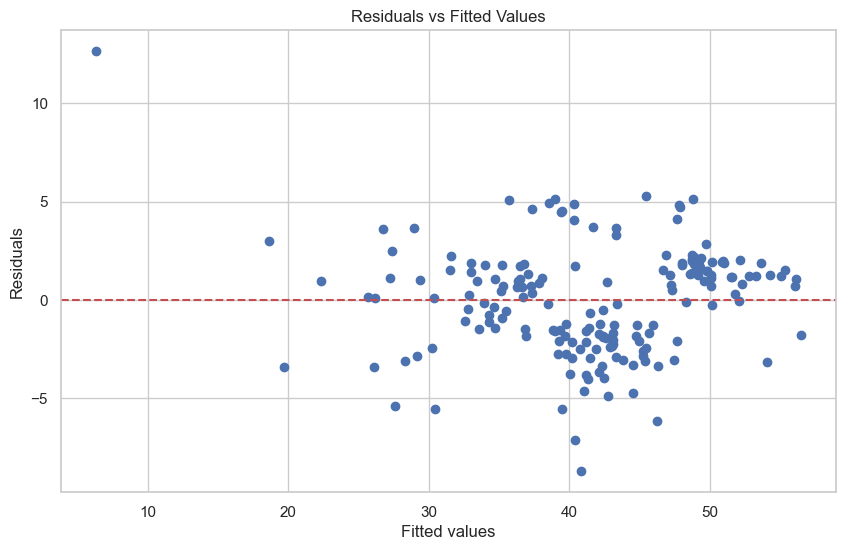

In [55]:
# 1. Visual inspection of residuals
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

Biểu đồ hình quạt => Phương sai không đồng nhất

**Correlation values between each independent variable and the squared residuals**

Để check đâu là nguyên nhân chính gây ra heterosdasticity

In [56]:
# Tạo DataFrame chứa bình phương phần dư và các biến độc lập
residual_analysis = pd.DataFrame()
residual_analysis['resid_squared'] = model.resid**2

# Tính hệ số tương quan
correlations = {}
for var in X.columns:
    if var != 'const':  
        residual_analysis[var] = df[var]
        corr = residual_analysis['resid_squared'].corr(residual_analysis[var])
        correlations[var] = corr

# Hiển thị kết quả tương quan
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
for var, corr in sorted_correlations:
    print(f"{var}: {corr:.4f}")


Carbon Footprint (tCO2e): 0.3686
ln_GNI: -0.2210
Average years of schooling: -0.1158
Unemployment: -0.1024
ln_Annual precipitation: -0.0786
stan_gini: 0.0769
Ladder of life (Wellbeing) (0-10): 0.0127


Absolute correlation close to 0 means less siginficant impact on heteroskedasticity

**Carbon Footprint**, **GNI** are more likely to contribute to heteroskedasticity.

In [73]:
#Breuch-Pagan test; for significant level of 0.05 

bp_test = sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog) #p_value có tăng so với không chia data
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:")
res = dict(zip(labels, bp_test))
print(res)
if res['p-value'] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")

Breusch-Pagan test:
{'Lagrange multiplier statistic': np.float64(56.8842415699014), 'p-value': np.float64(6.3028823960983e-10), 'f-value': np.float64(11.352950234784991), 'f p-value': np.float64(8.443048381731617e-12)}
Reject the null hypothesis of homoscedasticity


In [61]:
#Breusch Pagan Test
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np

# Kiểm định riêng lẻ cho từng biến. Với mỗi biến var, tạo một mô hình hồi quy đơn biến để test:
bp_results = {}
for var in X.columns:
    if var != 'const': 
        X_single = sm.add_constant(df[[var]])
        bp_test = het_breuschpagan(model.resid, X_single)
        bp_results[var] = bp_test[1]  # p-value

# Hiển thị kết quả theo thứ tự tăng dần của p-value
sorted_bp = sorted(bp_results.items(), key=lambda x: x[1])
for var, p_value in sorted_bp:
    significance = "Significant" if p_value < 0.05 else "Not significant"
    print(f"{var}: p-value = {p_value:.4f} ({significance})")

Carbon Footprint (tCO2e): p-value = 0.0000 (Significant)
ln_GNI: p-value = 0.0030 (Significant)
Average years of schooling: p-value = 0.1204 (Not significant)
Unemployment: p-value = 0.1695 (Not significant)
ln_Annual precipitation: p-value = 0.2916 (Not significant)
stan_gini: p-value = 0.3021 (Not significant)
Ladder of life (Wellbeing) (0-10): p-value = 0.8651 (Not significant)


p-value Analysis for Heteroskedasticity:

If p-value < 0.05: This indicates the presence of heteroskedasticity (result: "Significant").

If p-value ≥ 0.05: There is not enough evidence to reject the null hypothesis (result: "Not significant").

**Analysis Conclusion:**
The analysis shows that variables **Carbon Footprint, GNI** have a significant impact on heteroskedasticity. 

In [62]:
# White test; for significant level of 0.05 
import statsmodels.stats.diagnostic as smd
residuals = model.resid

white_test = smd.het_white(residuals, X)
labels = ['Test Statistic', 'p-value', 'F-statistic', 'F p-value']
print('White Test:')
print(dict(zip(labels, white_test)))
if white_test[1] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")

White Test:
{'Test Statistic': np.float64(147.1862695024755), 'p-value': np.float64(1.0404576614107724e-15), 'F-statistic': np.float64(18.45466384868148), 'F p-value': np.float64(7.573643688141309e-38)}
Reject the null hypothesis of homoscedasticity


## Solve Heteroskedasticity

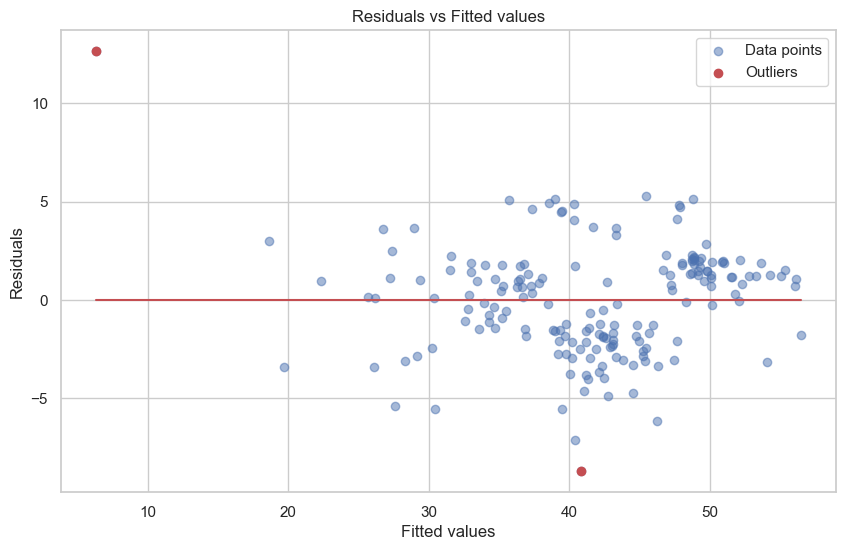

In [63]:
#Outlier detection 
# Calculate the z-scores of the residuals
import scipy.stats as stats
residuals = model.resid 
fitted = model.fittedvalues
z_scores = np.abs(stats.zscore(residuals))

# Define a threshold for outliers
threshold = 3

# Create a boolean mask for the outliers
outliers = z_scores > threshold

# Draw a plot
plt.figure(figsize=(10,6))
plt.scatter(fitted, residuals, alpha=0.5, label='Data points')
plt.scatter(fitted[outliers], residuals[outliers], color='r', label='Outliers')
plt.plot([fitted.min(), fitted.max()], [0, 0], 'r-')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.legend()
plt.show()

Remove ouliers để giảm chênh lệch giữa y và fitted value

In [64]:
#Creating a new df with removed outliers 

df['residuals'] = model.resid 
df_new = df.copy()
df_new['z_scores'] = np.abs(stats.zscore(df_new['residuals']))
df_new = df_new[df_new['z_scores'] < 3]
df_new = df_new.drop(columns = ['z_scores'])
len(df_new)

178

In [65]:
print(df_new)

    Country Name  ISO  Year      Continent  Population (thousands)  \
0        Algeria  DZA  2011         Africa                 36543.5   
1        Armenia  ARM  2011           Asia                  2929.0   
3        Belarus  BLR  2011         Europe                  9707.0   
5        Bolivia  BOL  2011  South America                 10396.2   
10         China  CHN  2011  North America               1357095.5   
..           ...  ...   ...            ...                     ...   
592    Indonesia  IDN  2021           Asia                273753.2   
601         Mali  MLI  2021         Africa                 21905.0   
602      Moldova  MDA  2021         Europe                  3061.5   
606     Paraguay  PRY  2021  South America                  6703.8   
616         Togo  TGO  2021           Asia                  8644.8   

     Life Expectancy (years)  Ladder of life (Wellbeing) (0-10)  \
0                       74.1                               5.32   
1                       7

In [66]:
#Fitting the new df 
X = df_new[['Ladder of life (Wellbeing) (0-10)','Carbon Footprint (tCO2e)','ln_GNI','ln_Annual precipitation', 'Average years of schooling', 'stan_gini','Unemployment']]
X = sm.add_constant(X) 
y = df_new['HPI'] 
model_new = sm.OLS(y, X).fit()
print(model_new.summary())

                            OLS Regression Results                            
Dep. Variable:                    HPI   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     255.8
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           9.24e-87
Time:                        22:28:09   Log-Likelihood:                -413.29
No. Observations:                 178   AIC:                             842.6
Df Residuals:                     170   BIC:                             868.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [67]:
#Using the new model summary, we test again: 
bp_test = sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:")
res = dict(zip(labels, bp_test))
print(res)
if res['p-value'] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")

Breusch-Pagan test:
{'Lagrange multiplier statistic': np.float64(56.8842415699014), 'p-value': np.float64(6.3028823960983e-10), 'f-value': np.float64(11.352950234784991), 'f p-value': np.float64(8.443048381731617e-12)}
Reject the null hypothesis of homoscedasticity


This method do not eliminate heterokedascity. 

**WLS**

In [68]:
y=df['HPI']
x=df[['Ladder of life (Wellbeing) (0-10)','Carbon Footprint (tCO2e)','ln_GNI','ln_Annual precipitation', 'Average years of schooling', 'stan_gini','Unemployment']]
x = sm.add_constant(x) 

model = sm.OLS(y, x).fit()

Try 1. The weight is the fitted value, inverse of the fitted values, inverse of square fitted value  obtained from the OLS model.

In [69]:

## add a intercept point
#w1 = model.fittedvalues
w1 = 1 / (model.fittedvalues**2 + 1e-5) #p_value lớn nhất trng 3 cái
#w1 = 1 / (model.fittedvalues + 1e-5)
model_wls_1 = sm.WLS(y, x, weights = w1) 
mod_res_1 = model_wls_1.fit() 
print(mod_res_1.summary())

residuals = mod_res_1.resid
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, mod_res_1.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:")
res = dict(zip(labels, bp_test))
print(res)
if res['p-value'] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")

                            WLS Regression Results                            
Dep. Variable:                    HPI   R-squared:                       0.932
Model:                            WLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     338.7
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           4.60e-97
Time:                        22:28:18   Log-Likelihood:                -467.99
No. Observations:                 180   AIC:                             952.0
Df Residuals:                     172   BIC:                             977.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Try 2. Ước lượng phương sai sai số dựa trên giá trị tuyệt đối của phần dư từ mô hình ban đầu. Bình phương các giá trị dự đoán này để tạo ra trọng số (weights) cho mô hình WLS.

In [70]:
model_residuals = model.resid
model_abs_resid = abs(model_residuals)
df["temp"] = model_abs_resid 
y_pred = model.fittedvalues

model_abs_resid = sm.OLS(df["temp"], sm.add_constant(y_pred)).fit()

# Get the fitted values from the new model
weights_2 = model_abs_resid.fittedvalues**2

# Use the fitted values as weights in a WLS model
model_wls_2 = sm.WLS(y, x, weights=weights_2)
result_wls_2 = model_wls_2.fit()
print(result_wls_2.summary())

residuals = result_wls_2.resid
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, result_wls_2.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:")
res = dict(zip(labels, bp_test))
print(res)
if res['p-value'] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")

                            WLS Regression Results                            
Dep. Variable:                    HPI   R-squared:                       0.889
Model:                            WLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     197.2
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           1.11e-78
Time:                        22:28:24   Log-Likelihood:                -452.76
No. Observations:                 180   AIC:                             921.5
Df Residuals:                     172   BIC:                             947.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Try 3. Như phần trên nhưng trọng số được lấy trực tiếp từ các giá trị dự đoán của mô hình OLS, mà không bình phương chúng.

In [72]:
df["temp"] = model_residuals**2  
y_pred = model.fittedvalues

model_abs_resid = sm.OLS(df["temp"], sm.add_constant(y_pred)).fit()

# Get the fitted values from the new model
weights_3 = model_abs_resid.fittedvalues

# Use the fitted values as weights in a WLS model
model_wls_2 = sm.WLS(y, x, weights=abs(weights_3))
result_wls_2 = model_wls_2.fit()
print(result_wls_2.summary())

residuals = result_wls_2.resid
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, result_wls_2.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:")
res = dict(zip(labels, bp_test))
print(res)
if res['p-value'] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")

                            WLS Regression Results                            
Dep. Variable:                    HPI   R-squared:                       0.871
Model:                            WLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     166.6
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           3.73e-73
Time:                        22:28:38   Log-Likelihood:                -470.21
No. Observations:                 180   AIC:                             956.4
Df Residuals:                     172   BIC:                             982.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

=> These methods of using weights do not eliminate heterokedascity. 